## 1. Set up the environment

In [1]:
!pip install keract

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

#from google.colab import files
from tensorflow import keras
from sklearn.model_selection import train_test_split

2023-06-28 08:17:06.526740: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 08:17:06.528335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 08:17:06.566268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 08:17:06.566789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 08:17:07.177214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [6]:
tf.sysconfig.get_build_info()

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [3]:
# kaggle_token_file = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# !mkdir ~/.kaggle

In [ ]:
# !mv /content/kaggle.json ~/.kaggle/kaggle.json

In [6]:
# !kaggle competitions download -c mds-ufu-dl-test --force

 54% 9.00M/16.7M [00:00<00:00, 35.8MB/s]
100% 16.7M/16.7M [00:00<00:00, 57.8MB/s]


In [7]:
# !unzip mds-ufu-dl-test.zip

Archive:  mds-ufu-dl-test.zip
  inflating: fmnist_test.csv         
  inflating: fmnist_train.csv        
  inflating: sample_submission.csv   


In [8]:
!ls -lah

total 88M
drwxr-xr-x 1 root root 4.0K Jun 14 01:53 .
drwxr-xr-x 1 root root 4.0K Jun 14 01:51 ..
drwxr-xr-x 4 root root 4.0K Jun 12 13:35 .config
-rw-r--r-- 1 root root  22M Apr 24 08:42 fmnist_test.csv
-rw-r--r-- 1 root root  50M Apr 24 08:42 fmnist_train.csv
-rw-r--r-- 1 root root  17M Jun 14 01:53 mds-ufu-dl-test.zip
drwxr-xr-x 1 root root 4.0K Jun 12 13:36 sample_data
-rw-r--r-- 1 root root  68K Apr 24 08:42 sample_submission.csv


## 2. Load datasets

### 2.1 Train dataset

In [9]:
# s1, s2 - slicing indices
def visualize_item(df, index, s1=1, s2=-1):
    pixels = df.iloc[index, s1:s2]
    pixels = pixels.values.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [10]:
train_df = pd.read_csv('/content/fmnist_train.csv')

In [11]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [12]:
train_df.isna().sum().sum()

424

In [13]:
train_df = train_df.fillna(0)

In [14]:
train_df.isna().sum().sum()

0

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17040 entries, 0 to 17039
Columns: 786 entries, label to Id
dtypes: float64(424), int64(362)
memory usage: 102.2 MB


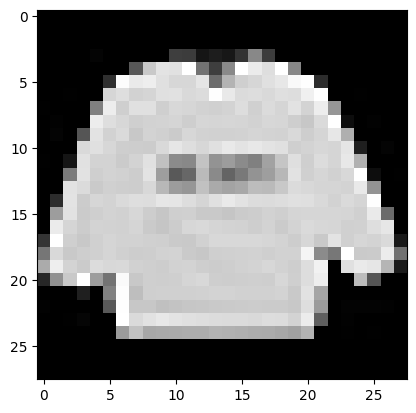

In [16]:
visualize_item(train_df, 0)

### 2.2 Test dataset

In [17]:
test_df = pd.read_csv('/content/fmnist_test.csv')

In [18]:
# just to be safe
test_df.isna().sum().sum()

0

In [19]:
test_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,0,0,0,0,0,0,0,9,8,0,...,87,56,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,63,53,31,0,0,0,2
3,0,0,0,0,0,0,0,0,0,161,...,126,140,0,133,224,222,56,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


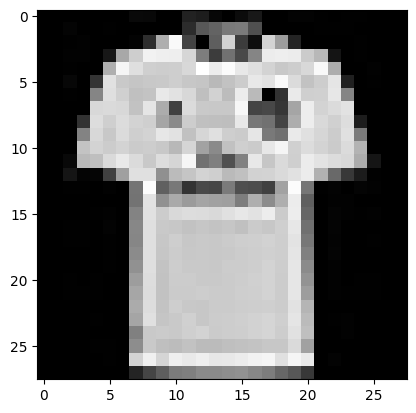

In [20]:
visualize_item(test_df, 0, s1=0)

## 3. Dataset preprocessing

In [22]:
# x_train
from sklearn.preprocessing import normalize

### 3.1 Train dataset data augmentation

### 3.1 Reshape

In [ ]:
Y_train = train_df['label'].to_numpy()

In [ ]:
display(Y_train)
display(len(Y_train))

array([2, 9, 6, ..., 4, 6, 5])

17040

In [ ]:
X_train = train_df.iloc[:, 1:785].to_numpy()

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [ ]:
aim = test_df.iloc[:, 0:784].to_numpy()

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train.shape

(11928, 28, 28, 1)

In [ ]:
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test.shape

(5112, 28, 28, 1)

In [ ]:
aim = aim.reshape(aim.shape[0], 28, 28, 1)
aim.shape

(10000, 28, 28, 1)

### 3.2 Normalize the dataset

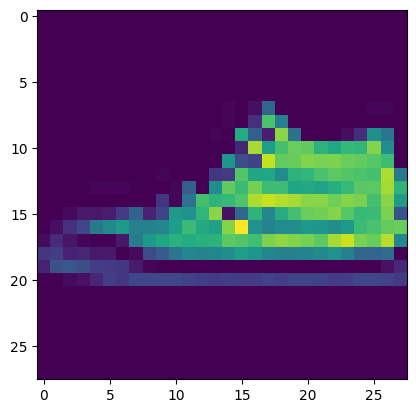

In [ ]:
plt.imshow(aim[31])
plt.show()

In [ ]:
train_x = x_train.astype('float32')
test_x = x_test.astype('float32')
val_x = aim.astype('float32')
train_x = train_x / 255
test_x = test_x / 255
val_x = val_x / 255
target_train = tf.keras.utils.to_categorical(y_train, 10)
target_test = tf.keras.utils.to_categorical(y_test, 10)

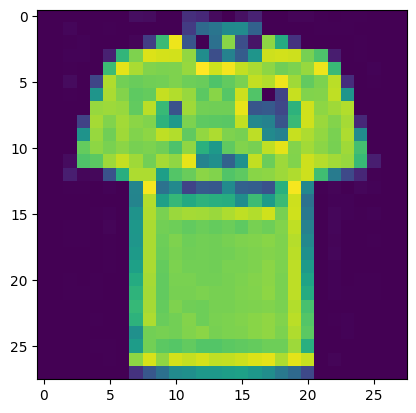

In [ ]:
plt.imshow(val_x[0])
plt.show()

In [ ]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## 4. Learning

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

In [ ]:
BATCH = 150
EPOCH_QTY = 35
VERBOSITY = 1
VALIDATION_SPLIT = 0.1

In [ ]:
model = Sequential()
input_shape = (28, 28, 1)
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(10, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(10, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
# model.compile( loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'] )
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

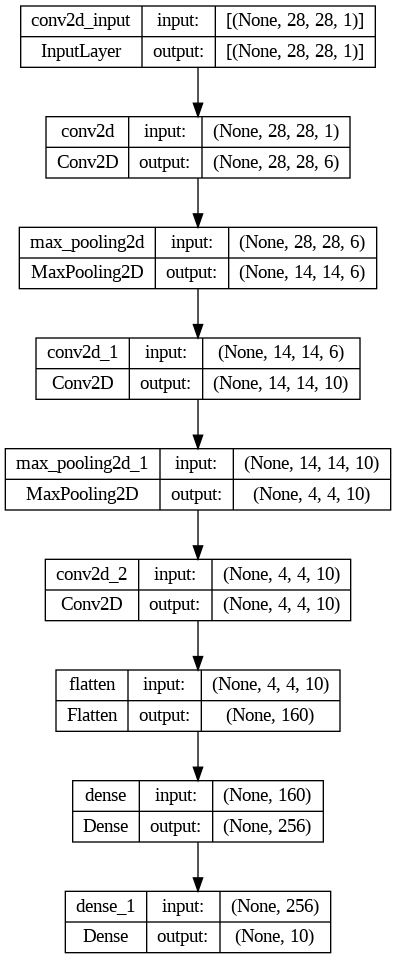

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model_history = model.fit(
    train_x,
    target_train,
    batch_size=BATCH,
    epochs=EPOCH_QTY,
    verbose=VERBOSITY,
    validation_split=VALIDATION_SPLIT
)

Epoch 1/35
72/72 [==============================] - 12s 114ms/step - loss: 1.2699 - accuracy: 0.5416 - val_loss: 0.7807 - val_accuracy: 0.7041
Epoch 2/35
72/72 [==============================] - 8s 109ms/step - loss: 0.7152 - accuracy: 0.7299 - val_loss: 0.6380 - val_accuracy: 0.7536
Epoch 3/35
72/72 [==============================] - 8s 117ms/step - loss: 0.6391 - accuracy: 0.7597 - val_loss: 0.5807 - val_accuracy: 0.7812
Epoch 4/35
72/72 [==============================] - 7s 99ms/step - loss: 0.5739 - accuracy: 0.7905 - val_loss: 0.5365 - val_accuracy: 0.7955
Epoch 5/35
72/72 [==============================] - 8s 116ms/step - loss: 0.5330 - accuracy: 0.8008 - val_loss: 0.5060 - val_accuracy: 0.8198
Epoch 6/35
72/72 [==============================] - 8s 106ms/step - loss: 0.5100 - accuracy: 0.8123 - val_loss: 0.4805 - val_accuracy: 0.8198
Epoch 7/35
72/72 [==============================] - 8s 107ms/step - loss: 0.4765 - accuracy: 0.8275 - val_loss: 0.4495 - val_accuracy: 0.8374
Epoch 

In [ ]:
test_loss, test_acc = model.evaluate(test_x, target_test, verbose=2)

print('\nTest accuracy:', test_acc)

160/160 - 1s - loss: 0.3636 - accuracy: 0.8781 - 1s/epoch - 9ms/step

Test accuracy: 0.8781298995018005


In [ ]:
prediction = model.predict(val_x)

313/313 [==============================] - 3s 9ms/step


In [ ]:
category=[]
for i in prediction:
    category.append(np.argmax(i))

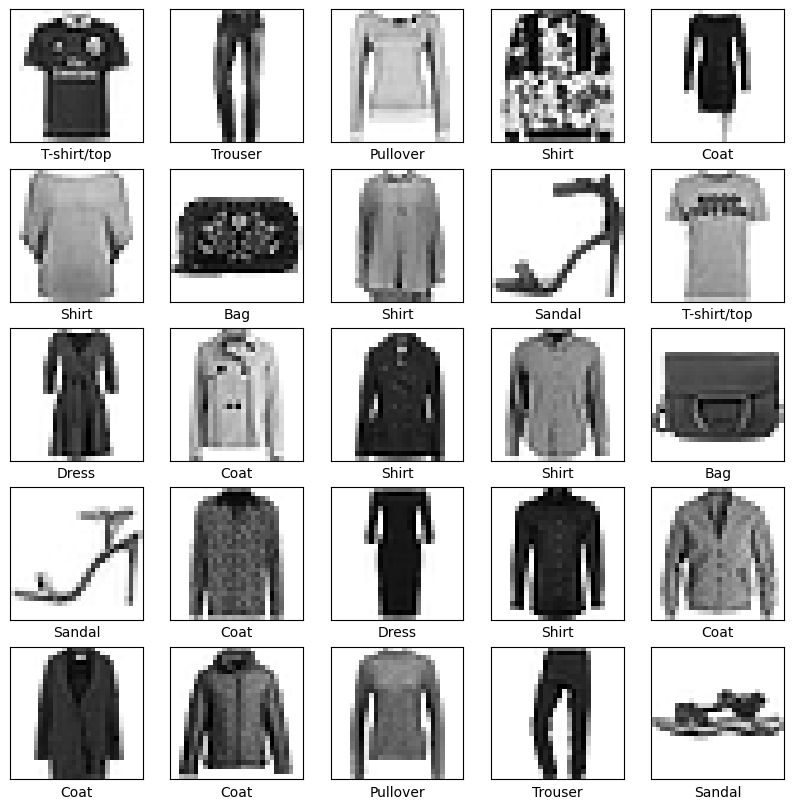

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0, 25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_x[i], cmap=plt.cm.binary)
    plt.xlabel(labels[category[i]])
plt.show()

In [ ]:
submission = {
    'Id': list(test_df.Id.values),
    'Category': category
}
solution = pd.DataFrame(submission)
solution.to_csv('submission_alex_petrosyan.csv', index=False)

In [ ]:
#!kaggle competitions submit -c mds-ufu-dl-test -f submission_alex_petrosyan.csv -m "Message"